<a href="https://colab.research.google.com/github/ali3brt/20-Newsgroups-Dataset/blob/main/variational_autoencoders_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Autoencoder

This is based on [Geron's notebook, chapter 17](https://github.com/ageron/handson-ml3/blob/main/17_autoencoders_gans_and_diffusion_models.ipynb), in accordance with Apache License v2

In [58]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

Load the data

In [59]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

This introduces Gaussian noise with `z_mean` and `z_log_var`

In [60]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit.
    Input:
      z_mean - mean vector
      z_log_var - log variance vector, which is the log of the square of the standard deviation
    Output: z
    """
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean

In [61]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

In [62]:
# the size of the latent space
codings_size = 10

#### Setting the Encoder

In [63]:
inputs = tf.keras.layers.Input(shape=[28, 28])
Z = tf.keras.layers.Flatten()(inputs)
Z = tf.keras.layers.Dense(150, activation="relu")(Z)
Z = tf.keras.layers.Dense(100, activation="relu")(Z)
codings_mean = tf.keras.layers.Dense(codings_size)(Z)  # μ
codings_log_var = tf.keras.layers.Dense(codings_size)(Z) # log(σ^2)
codings = Sampling()([codings_mean, codings_log_var])

In [64]:
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [65]:
variational_encoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 28, 28)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 784)            │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_42 (Dense)          │ (None, 150)            │        117,750 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_43 (Dense)          │ (None, 100)            │         15,100 │ dense_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_44 (Dense)          │ (None, 10)             │          1,010 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_45 (Dense)          │ (None, 10)             │          1,010 │ dense_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_3 (Sampling)     │ (None, 10)             │              0 │ dense_44[0][0],        │
│                           │                        │                │ dense_45[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 134,870 (526.84 KB)

 Trainable params: 134,870 (526.84 KB)

 Non-trainable params: 0 (0.00 B)

#### Setting the Decoder

In [66]:
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
x = tf.keras.layers.Dense(100, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu")(x)
x = tf.keras.layers.Dense(28 * 28)(x)
outputs = tf.keras.layers.Reshape([28, 28])(x)

In [67]:
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [68]:
variational_decoder.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 100)                 │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 784)                 │         118,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 28, 28)              │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 134,634 (525.91 KB)

 Trainable params: 134,634 (525.91 KB)

 Non-trainable params: 0 (0.00 B)

#### Setting the Variational Autoencoder

In [69]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

In [70]:
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

In [71]:
variational_ae.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_9 (Functional)            │ [(None, 10), (None, 10),    │         134,870 │
│                                      │ (None, 10)]                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 28, 28)              │         134,634 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,504 (1.03 MB)

 Trainable params: 269,504 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

#### Setting the latent loss function

The latent loss that pushes the autoencoder to have codings that look as though they were sampled from a simple
Gaussian distribution: it is the KL divergence between the target distribution (i.e.,
the Gaussian distribution) and the actual distribution of the coding.

It computes the latent loss for each instance in the batch, summing over the last axis. Then we compute the mean loss over all the instances in the batch, and we divide the result by 784 to ensure it has the appropriate scale compared to the reconstruction loss.

In [72]:
import tensorflow as tf

class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        codings_mean, codings_log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=tf.shape(codings_mean))
        codings = codings_mean + tf.exp(0.5 * codings_log_var) * epsilon
        reconstructions = self.decoder(codings)
        return reconstructions

    def train_step(self, data):
        # Unpack the data
        x, _ = data

        with tf.GradientTape() as tape:
            # Forward pass
            codings_mean, codings_log_var = self.encoder(x)
            epsilon = tf.random.normal(shape=tf.shape(codings_mean))
            codings = codings_mean + tf.exp(0.5 * codings_log_var) * epsilon
            reconstructions = self.decoder(codings)

            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(tf.square(x - reconstructions))

            # Compute latent loss
            latent_loss = -0.5 * tf.reduce_sum(
                1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
                axis=-1
            )
            latent_loss = tf.reduce_mean(latent_loss) / 784.

            # Total loss
            total_loss = reconstruction_loss + latent_loss

        # Compute gradients and update weights
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Return a dictionary of metrics
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "latent_loss": latent_loss}

# Initialize your encoder and decoder models
encoder = ... # Define your encoder model here
decoder = ... # Define your decoder model here

# Create the VAE model
variational_ae = VariationalAutoencoder(encoder, decoder)
variational_ae.compile(optimizer="adam")


#### Setting the Optimizer

In [73]:
variational_ae.compile(loss="mse", optimizer="nadam")

In [74]:
from tensorflow.keras import layers, models

# Define the Encoder model
latent_dim = 2  # Adjust this as needed
encoder_inputs = layers.Input(shape=(784,))  # Example input shape for a flattened 28x28 image
x = layers.Dense(256, activation="relu")(encoder_inputs)
x = layers.Dense(128, activation="relu")(x)
codings_mean = layers.Dense(latent_dim)(x)
codings_log_var = layers.Dense(latent_dim)(x)
encoder = models.Model(encoder_inputs, [codings_mean, codings_log_var], name="encoder")

# Define the Decoder model
decoder_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(decoder_inputs)
x = layers.Dense(256, activation="relu")(x)
decoder_outputs = layers.Dense(784, activation="sigmoid")(x)
decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")

# Create the Variational Autoencoder model
variational_ae = VariationalAutoencoder(encoder, decoder)
variational_ae.compile(optimizer="adam")


#### Training

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Encoder class definition
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.latent_mean = layers.Dense(latent_dim)  # Mean output layer
        self.latent_log_var = layers.Dense(latent_dim)  # Log variance output layer

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        mean = self.latent_mean(x)
        log_var = self.latent_log_var(x)
        return mean, log_var

# Decoder class definition
class Decoder(tf.keras.Model):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(512, activation='relu')
        self.output_layer = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Variational Autoencoder definition
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim, original_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)

    def call(self, inputs):
        # Encode input to latent space
        mean, log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization trick
        # Decode latent vector to reconstructed input
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Forward pass through encoder and decoder
            mean, log_var = self.encoder(data)
            epsilon = tf.random.normal(shape=tf.shape(mean))
            z = mean + tf.exp(0.5 * log_var) * epsilon
            reconstructed = self.decoder(z)
            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstructed)
            )
            # Compute KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

# Setting hyperparameters
latent_dim = 2
original_dim = 28 * 28

# Create and compile the Variational Autoencoder
variational_ae = VariationalAutoencoder(latent_dim, original_dim)
variational_ae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Flattening the training and validation data
X_train_flattened = X_train.reshape(-1, 28 * 28)
X_valid_flattened = X_valid.reshape(-1, 28 * 28)

# Initialize weights by running a forward pass
variational_ae.encoder(X_train_flattened[:1])
variational_ae.decoder(tf.random.normal((1, latent_dim)))

# Train the model
history = variational_ae.fit(
    X_train_flattened, X_train_flattened, epochs=25, batch_size=128,
    validation_data=(X_valid_flattened, X_valid_flattened)
)

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - kl_loss: 0.0069 - loss: 0.5058 - reconstruction_loss: 0.4989 - val_loss: 0.0878
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - kl_loss: 1.2323e-04 - loss: 0.4907 - reconstruction_loss: 0.4906 - val_loss: 0.0878
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 6.3492e-05 - loss: 0.4906 - reconstruction_loss: 0.4905 - val_loss: 0.0877
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 3.9501e-05 - loss: 0.4905 - reconstruction_loss: 0.4904 - val_loss: 0.0876
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - kl_loss: 2.9869e-05 - loss: 0.4904 - reconstruction_loss: 0.4904 - val_loss: 0.0876
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 1.9066e-05 - loss: 0.4904 - reconstruction_loss: 0.4903 - val_loss: 0.0876
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 1.6699e-05 - loss: 0.4903 - reconstruction_loss: 0.4903 - val_loss: 0.0876
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━

#### Plot Reconstructions

In [76]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

Epoch 1/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - kl_loss: 0.0048 - loss: 0.5037 - reconstruction_loss: 0.4989 - val_loss: 0.0879
Epoch 2/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - kl_loss: 1.1031e-04 - loss: 0.4907 - reconstruction_loss: 0.4906 - val_loss: 0.0878
Epoch 3/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 4.4786e-05 - loss: 0.4906 - reconstruction_loss: 0.4905 - val_loss: 0.0877
Epoch 4/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 2.2218e-05 - loss: 0.4905 - reconstruction_loss: 0.4905 - val_loss: 0.0877
Epoch 5/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 1.2493e-05 - loss: 0.4904 - reconstruction_loss: 0.4904 - val_loss: 0.0876
Epoch 6/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 7.9450e-06 - loss: 0.4904 - reconstruction_loss: 0.4904 - val_loss: 0.0876
Epoch 7/25
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - kl_loss: 6.9014e-06 - loss: 0.4903 - reconstruction_loss: 0.4903 - val_loss: 0.0876
Epoch 8/25
430/430 ━━━━━━━━━━━━━━━━━━━

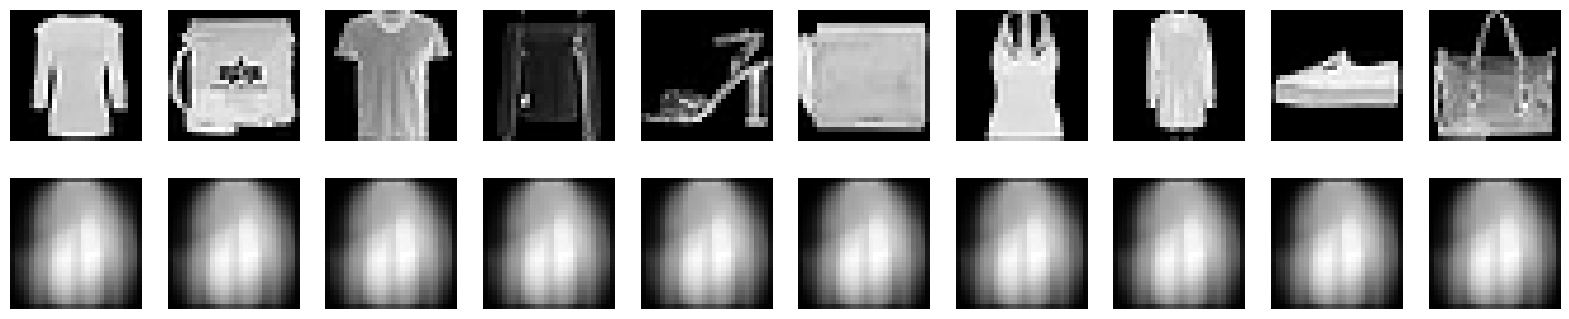

In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Encoder class definition
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(512, activation='relu')
        self.dense2 = layers.Dense(256, activation='relu')
        self.latent_mean = layers.Dense(latent_dim)  # Mean output layer
        self.latent_log_var = layers.Dense(latent_dim)  # Log variance output layer

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        mean = self.latent_mean(x)
        log_var = self.latent_log_var(x)
        return mean, log_var

# Decoder class definition
class Decoder(tf.keras.Model):
    def __init__(self, original_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(256, activation='relu')
        self.dense2 = layers.Dense(512, activation='relu')
        self.output_layer = layers.Dense(original_dim, activation='sigmoid')

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        return self.output_layer(x)

# Variational Autoencoder definition
class VariationalAutoencoder(tf.keras.Model):
    def __init__(self, latent_dim, original_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(original_dim)

    def call(self, inputs):
        # Encode input to latent space
        mean, log_var = self.encoder(inputs)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization trick
        # Decode latent vector to reconstructed input
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Forward pass through encoder and decoder
            mean, log_var = self.encoder(data)
            epsilon = tf.random.normal(shape=tf.shape(mean))
            z = mean + tf.exp(0.5 * log_var) * epsilon
            reconstructed = self.decoder(z)
            # Compute reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstructed)
            )
            # Compute KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mean) - tf.exp(log_var))
            # Total loss
            total_loss = reconstruction_loss + kl_loss
        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss, "reconstruction_loss": reconstruction_loss, "kl_loss": kl_loss}

# Setting hyperparameters
latent_dim = 2
original_dim = 28 * 28

# Create and compile the Variational Autoencoder
variational_ae = VariationalAutoencoder(latent_dim, original_dim)
variational_ae.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Flattening the training and validation data
X_train_flattened = X_train.reshape(-1, 28 * 28)
X_valid_flattened = X_valid.reshape(-1, 28 * 28)

# Initialize weights by running a forward pass
variational_ae.encoder(X_train_flattened[:1])
variational_ae.decoder(tf.random.normal((1, latent_dim)))

# Train the model
history = variational_ae.fit(
    X_train_flattened, X_train_flattened, epochs=25, batch_size=128,
    validation_data=(X_valid_flattened, X_valid_flattened)
)

# Function to plot reconstructions
def plot_reconstructions(model, data, num_images=10):
    data = data[:num_images]
    reconstructions = model(data)
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        # Original images
        axes[0, i].imshow(data[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed images
        axes[1, i].imshow(reconstructions[i].numpy().reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')
    plt.show()

# Plot reconstructions
plot_reconstructions(variational_ae, X_valid_flattened[:10])


## Generate Fashion Images

Let's generate a few random codings, and decode them:

In [79]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

codings = tf.random.normal(shape=[3 * 7, codings_size])
images = variational_decoder(codings).numpy()

Now let's plot these images:

In [80]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

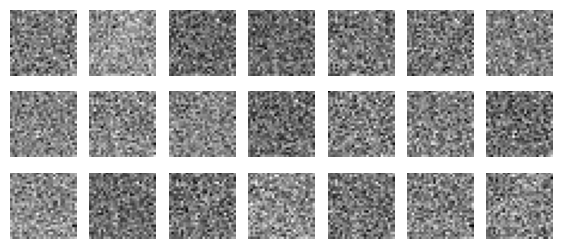

In [81]:
plot_multiple_images(images, 7)
plt.show()

Now let's perform semantic interpolation between 2 images:

In [82]:
tf.random.set_seed(42)

In [83]:
codings = np.zeros([7, codings_size])
codings[:, 3] = np.linspace(-0.8, 0.8, 7)  # axis 3 looks best in this case

In [84]:
codings

array([[ 0.        ,  0.        ,  0.        , -0.8       ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.53333333,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.26666667,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.26666667,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.53333333,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.8       ,  0.        ,
         0.        ,  0.        ,  0.        

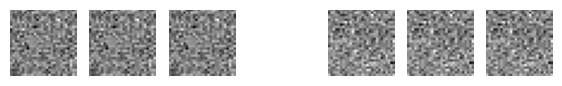

In [85]:
images = variational_decoder(codings).numpy()
plot_multiple_images(images)
plt.show()